In [25]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## Define arm model(look at writeup for details)

In [2]:
def calculate_angles(P, alpha, x, y, theta_1):
    u = np.array([1, 0])
    v = np.array([0, 1])
    R = P + np.array([alpha * np.cos(np.radians(180) - theta_1), alpha * np.sin(np.radians(180) - theta_1)])
    if(max(x, y, norm(R)) > sum([x, y, norm(R)]) - max(x, y, norm(R))):
        #print("not a triangle!")
        return None, None
    if(abs((norm(R) ** 2 + x ** 2 - y ** 2) / (2 * x * norm(R))) > 1):
        print("invalid theta for", x, y, norm(R))
        
    qor = np.arccos((norm(R) ** 2 + x ** 2 - y ** 2) / (2 * x * norm(R)))
    oqr = np.arccos((x ** 2 + y ** 2  - norm(R) ** 2)/(2 * x * y))
    
    
    theta_R = np.arccos(np.dot(R, u)/norm(R))
    theta_R = 2 * np.pi - theta_R if np.dot(R, v) < 0 else theta_R


    rotation_matrix = np.array([[np.cos(np.pi/2), -np.sin(np.pi/2)],
                                [np.sin(np.pi/2), np.cos(np.pi/2)]])
    

    if np.dot(np.array([x * np.cos(theta_R - qor), x * np.sin(theta_R - qor)]), rotation_matrix @ R) > 0:
        theta_2 = theta_R - qor
    elif np.dot(np.array([x * np.cos(theta_R + qor), x * np.sin(theta_R + qor)]), rotation_matrix @ R) > 0: 
        theta_2 = theta_R + qor
    else:
        return None, None
    
    Q = np.array([x * np.cos(theta_2), y * np.sin(theta_2)])

    return np.pi - theta_2, oqr

## Define measured locations

In [3]:
P = np.array([25.5, 9])

## 1. Gridsearch $x, y, \alpha$

### Define length bounds
$x_{min} <= x <= x_{max}$

$y_{min} <= y <= y_{max}$

$-\theta_{limit} <= \theta_1 <= \theta_{limit}$

In [30]:
xmin = 3
xmax = 14
ymin = 3
ymax = 14
alpha_min = 30
alpha_max = 35
theta_limit = np.deg2rad(10)

In [31]:
x_grid = list(np.linspace(xmin, xmax, 20))  # too lazy to vectorize the simulation
y_grid = list(np.linspace(ymin, ymax, 20))
alpha_grid = list(np.linspace(alpha_min, alpha_max, 10))
combinations = list(itertools.product(x_grid, y_grid, alpha_grid))
len(combinations)

4000

### Perform grid search

In [32]:
result_df = pd.DataFrame({"x": [i[0] for i in combinations], "y": [i[1] for i in combinations], "alpha": [i[2] for i in combinations]})
# below are result columns
result_df.head()

,x,y,alpha
0,3.0,3.0,30.000000
1,3.0,3.0,30.555556
2,3.0,3.0,31.111111
3,3.0,3.0,31.666667
4,3.0,3.0,32.222222


In [33]:
%%time
theta2_mins = []
theta2_maxs = []
oqr_mins = []
oqr_maxs = []
dtheta_maxs = []
dtheta_sums = []
theta2_at_theta1_0 = []
oqr_at_theta1_0 = []
for index, row in result_df.iterrows():
    x = row["x"]
    y = row["y"]
    alpha = row["alpha"]
    theta2_min = float("inf")
    theta2_max = float("-inf")
    oqr_min = float("inf")
    oqr_max = float("-inf")
    dtheta = []
    theta2_prev = 0
    thetas = list(np.linspace(-theta_limit, theta_limit))
    for index, theta_1 in enumerate(thetas):  # almost same performance as np.vectorize
        theta2, oqr = calculate_angles(P, alpha, x, y, theta_1)
        if not theta2 or not oqr:
            theta2_min = np.nan
            theta2_max = np.nan
            oqr_min = np.nan
            oqr_max = np.nan
            dtheta_sum = np.nan
            break
        theta2_min = min(theta2_min, theta2)
        theta2_max = max(theta2_max, theta2)
        oqr_min = min(oqr_min, oqr)
        oqr_max = max(oqr_max, oqr)
        if index > 0:
            dtheta.append((theta2 - theta2_prev) / (theta_1 - thetas[index - 1]))
        theta2_prev = theta2
    
    if np.isnan(theta2_min):
        dtheta_maxs.append(np.nan)
        dtheta_sums.append(np.nan)
        theta2_mins.append(theta2_min)
        theta2_maxs.append(theta2_max)
        oqr_mins.append(oqr_min)
        oqr_maxs.append(oqr_max)
        theta2_at_theta1_0.append(np.nan)
        oqr_at_theta1_0.append(np.nan)
    else:
        dtheta_maxs.append(np.rad2deg(max(dtheta)))
        dtheta_sums.append(sum(dtheta))
        theta2_mins.append(np.rad2deg(theta2_min))
        theta2_maxs.append(np.rad2deg(theta2_max))
        oqr_mins.append(np.rad2deg(oqr_min))
        oqr_maxs.append(np.rad2deg(oqr_max))
        t0, o0  = calculate_angles(P, alpha, x, y, 0)
        theta2_at_theta1_0.append(np.rad2deg(t0))
        oqr_at_theta1_0.append(np.rad2deg(o0))
        

        
result_df["theta2_min"] = theta2_mins
result_df["theta2_max"] = theta2_maxs
result_df["theta2@0"] = theta2_at_theta1_0
result_df["oqr@0"] = oqr_at_theta1_0
result_df["oqr_min"] = oqr_mins
result_df["oqr_max"] = oqr_maxs
result_df["dtheta_max"] = dtheta_maxs
result_df["dtheta_sum"] = dtheta_sums
result_df = result_df.copy()

CPU times: user 9.53 s, sys: 34 µs, total: 9.53 s
Wall time: 9.49 s


In [34]:
result_df = result_df.loc[np.logical_not(np.isnan(result_df["theta2_min"]))]
result_df

,x,y,alpha,theta2_min,theta2_max,theta2@0,oqr@0,oqr_min,oqr_max,dtheta_max,dtheta_sum
589,4.157895,13.421053,35.000000,-142.295123,52.691906,-42.114003,76.442610,13.674849,171.406817,1475.763420,477.718221
731,4.736842,10.526316,30.555556,-125.083287,57.029369,-18.602773,74.480595,8.929829,158.057094,1554.255527,446.176008
743,4.736842,11.105263,31.666667,-121.262323,52.347191,-24.311005,75.277781,15.903772,156.908079,1023.932632,425.343309
754,4.736842,11.684211,32.222222,-132.428586,43.286076,-30.225156,72.779676,11.369827,147.073377,1230.350726,430.500920
755,4.736842,11.684211,32.777778,-117.118101,49.750649,-28.513346,76.951122,22.793193,158.311723,819.507050,408.828437
...,...,...,...,...,...,...,...,...,...,...,...
3995,14.000000,14.000000,32.777778,-48.360009,10.529850,-14.543725,48.833466,31.259987,70.603411,239.738857,144.280155
3996,14.000000,14.000000,33.333333,-49.728537,9.759721,-15.813413,50.443865,33.202839,72.232142,235.911277,145.746231
3997,14.000000,14.000000,33.888889,-50.811137,9.091164,-16.921196,52.132085,35.206626,73.940075,231.515933,146.760638
3998,14.000000,14.000000,34.444444,-51.645995,8.522329,-17.875503,53.894222,37.264900,75.726588,226.816286,147.412394


### condition 1: min, max angle of $\theta_2$

$-60° <= \theta_2 <= 60°$

-55 is the lowest the lower arm can go before hitting the backplate. 50 seems like a reasonable max angle

In [49]:
cond1 = result_df.loc[np.logical_and(result_df["theta2_min"] >= -35, result_df["theta2_max"] <= 50)]
cond1

,x,y,alpha,theta2_min,theta2_max,theta2@0,oqr@0,oqr_min,oqr_max,dtheta_max,dtheta_sum
1890,8.210526,8.210526,30.000000,-27.126791,48.229430,11.224912,75.579926,39.455414,128.233241,270.944910,184.622743
1891,8.210526,8.210526,30.555556,-30.150216,48.406775,9.624772,77.897862,42.061000,132.400629,281.200257,192.464629
1892,8.210526,8.210526,31.111111,-32.545790,48.990223,8.289221,80.461955,44.914084,137.251068,307.073915,199.763232
1900,8.210526,8.789474,30.000000,-33.591558,43.330204,7.022038,72.493341,37.865697,120.657846,294.904009,188.458317
2090,8.789474,8.210526,30.000000,-22.251741,45.553261,12.341200,72.493341,37.865697,120.657846,241.030354,166.122256
...,...,...,...,...,...,...,...,...,...,...,...
3971,14.000000,12.842105,30.555556,-27.675964,19.830218,-0.886672,44.977391,24.885234,67.917606,197.763275,116.390145
3972,14.000000,12.842105,31.111111,-31.363119,18.587248,-3.031354,46.298164,26.580774,69.302559,208.106777,122.378399
3973,14.000000,12.842105,31.666667,-34.502590,17.452394,-4.986705,47.723530,28.389022,70.779173,214.406317,127.289711
3980,14.000000,13.421053,30.000000,-29.381872,18.585388,-2.000721,42.991139,23.200330,65.160554,207.118763,117.519787


### condition2 : min, max angle of OQR

In [59]:
cond2 = cond1.loc[np.logical_and(result_df["oqr_min"] >= 50, result_df["oqr_max"] <= 120)]
cond2

,x,y,alpha,theta2_min,theta2_max,theta2@0,oqr@0,oqr_min,oqr_max,dtheta_max,dtheta_sum
2908,11.105263,8.789474,34.444444,-30.884228,34.099428,2.465247,78.302778,51.864276,119.042620,214.399152,159.209957
2918,11.105263,9.368421,34.444444,-34.705116,30.762738,-0.598306,76.070205,50.958249,113.887235,220.282014,160.396242
3109,11.684211,8.789474,35.000000,-29.690285,32.801520,2.372491,78.050938,52.581327,117.232858,204.618135,153.104923
3119,11.684211,9.368421,35.000000,-33.282628,29.673473,-0.541221,75.979692,51.822279,112.414866,209.761078,154.242449
3299,12.263158,8.210526,35.000000,-23.943705,34.502558,5.831645,76.635157,50.227196,116.536920,190.273257,143.193345


## optimal values:
$\alpha = 34.4$

$x = 11.1$

$y = 9.3$

## 2. Verify optimal values are valid

In [97]:
alpha = 34.4
x = 11.1
y = 9.36

<IPython.core.display.Javascript object>


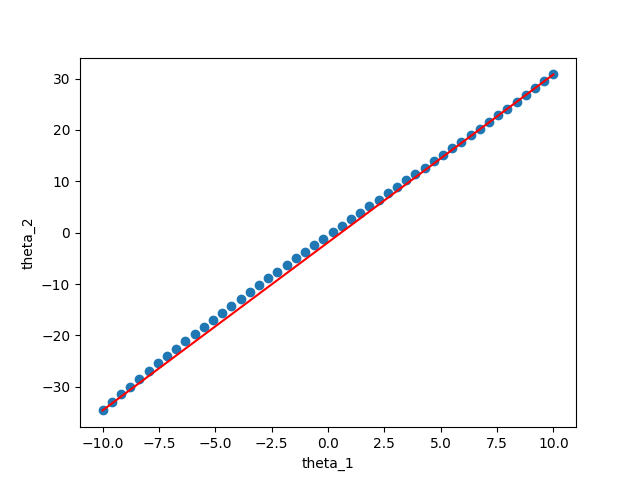

<IPython.core.display.Javascript object>


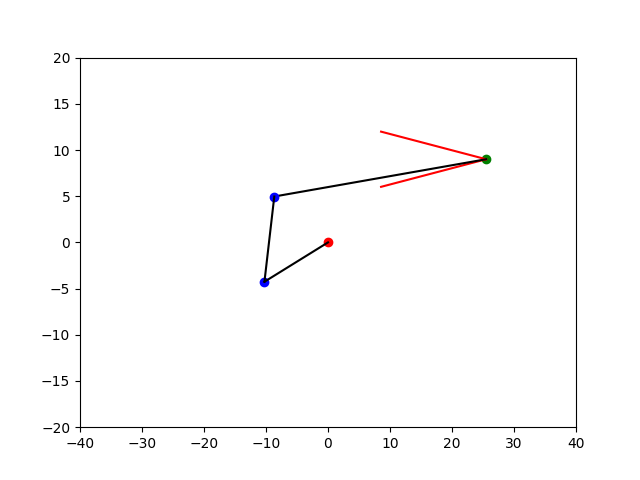

(-10.0, -34.59716092064957) (10.0, 30.80903081285573)


In [100]:
%matplotlib notebook

f1, a1 = plt.subplots()
a1.set_xlabel("theta_1")
a1.set_ylabel("theta_2")
fig, ax = plt.subplots()
ax.set_xlim([-40, 40])
ax.set_ylim([-20, 20])

n_thetas = 50
max_theta1_angle = np.deg2rad(10)
thetas = np.linspace(-max_theta1_angle, max_theta1_angle, n_thetas)


theta_2s = []
for i in list(thetas):
    theta_2s.append(np.rad2deg(calculate_angles(P, alpha, x, y, i)[0]))
a1.scatter(np.rad2deg(thetas), theta_2s)
plot_2_points((np.rad2deg(thetas[0]), theta_2s[0]), (np.rad2deg(thetas[-1]), theta_2s[-1]), a1, "r")

print((np.rad2deg(thetas[0]), theta_2s[0]), (np.rad2deg(thetas[-1]), theta_2s[-1]))

last_successful_i = 0
def plot_2_points(a, b, ax, color="k"):
    xvals = [a[0], b[0]]
    yvals = [a[1], b[1]]
    ax.plot(xvals, yvals, f"{color}-")

def update_simulation(i):
    ax.clear()
    ax.set_xlim([-40, 40])
    ax.set_ylim([-20, 20])
    origin = np.array([0, 0])
    ax.plot(*origin, "ro", label="O")
    ax.plot(*P, "go", label="O")
    #plot_2_points(origin, P, ax)
    plot_2_points(P, P + np.array([alpha/2 * np.cos(np.radians(180) + max_theta1_angle), alpha/2 * np.sin(np.radians(180) + max_theta1_angle)]), ax, "r")
    plot_2_points(P, P + np.array([alpha/2 * np.cos(np.radians(180) - max_theta1_angle), alpha/2 * np.sin(np.radians(180) - max_theta1_angle)]), ax, "r")
    
    theta2, oqr = calculate_angles(P, alpha, x, y, thetas[i])
    
    if not theta2:
        theta2, oqr = calculate_angles(P, alpha, x, y, thetas[last_successful_i])
        R = P + np.array([alpha * np.cos(np.radians(180) - thetas[last_successful_i]), alpha * np.sin(np.radians(180) - thetas[last_successful_i])])
    else:
        theta_2s.append(theta2)
        last_successful_i = i
        R = P + np.array([alpha * np.cos(np.radians(180) - thetas[i]), alpha * np.sin(np.radians(180) - thetas[i])])
        
    plot_2_points(P, R, ax)
    ax.plot(*R, "bo", label="O")
    
    Q = origin + np.array([x * np.cos(-theta2 - np.pi), x * np.sin(- theta2 - np.pi)])
    ax.plot(*Q, "bo", label="O")
    plot_2_points(origin, Q, ax)
    
    plot_2_points(Q, R, ax)


anim = animation.FuncAnimation(fig, update_simulation, frames=n_thetas, interval=50)

#writer = animation.writers['ffmpeg']
#anim.save("test3.mp4", writer="ffmpeg")

In [101]:
(-34.59716092064957 - 30.80903081285573)/(-10.0 - 10.0)

3.270309586675265